In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

In [6]:
cwd = os.getcwd()
os.chdir(r'C:\Users\ekoulier\Desktop\GGD\New Data\Central_Folder')
data = pd.read_csv('brabant_lim.csv')
os.chdir(cwd)

In [7]:
data.head()

,HVB,Date,WB,BZO,Trends,SLIM,NLIM
0,29,2004-01,3,20,0,4,7
1,26,2004-02,12,11,0,8,15
2,43,2004-03,5,23,57,7,16
3,22,2004-04,8,44,47,8,18
4,41,2004-05,18,39,0,8,19


In [8]:
def create_lag(df, n_lags):
    """
    Manipulates the dataset in order to create time lags for 'HVB', 'WB', 'BZO' and 'Trends'.
    """
    
    assert type(n_lags) == int
 
    for i in ['HVB', 'WB', 'BZO', 'Trends', 'SLIM', 'NLIM']:
        for j in range(1, n_lags + 1):
            df[i+'-'+str(j)] = df[i].shift(j)
        df[i+'+1'] = df[i].shift(-1)
        
    # We dont need to forecast the google trends    
    del df['Trends+1']
    
    # Due to the shift that creates nans, we delete the first n_lags rows and the last row.
    df = df[n_lags:].reset_index(drop = True)
    df = df[:-1]
    
    return df

In [9]:
data2 = create_lag(data, 3)

In [10]:
data2.head()

,HVB,Date,WB,BZO,Trends,SLIM,NLIM,HVB-1,HVB-2,HVB-3,...,Trends-2,Trends-3,SLIM-1,SLIM-2,SLIM-3,SLIM+1,NLIM-1,NLIM-2,NLIM-3,NLIM+1
0,22,2004-04,8,44,47,8,18,43.0,26.0,29.0,...,0.0,0.0,7.0,8.0,4.0,8.0,16.0,15.0,7.0,19.0
1,41,2004-05,18,39,0,8,19,22.0,43.0,26.0,...,57.0,0.0,8.0,7.0,8.0,19.0,18.0,16.0,15.0,31.0
2,63,2004-06,26,68,39,19,31,41.0,22.0,43.0,...,47.0,57.0,8.0,8.0,7.0,19.0,19.0,18.0,16.0,31.0
3,40,2004-07,45,101,0,19,31,63.0,41.0,22.0,...,0.0,47.0,19.0,8.0,8.0,28.0,31.0,19.0,18.0,33.0
4,54,2004-08,50,58,0,28,33,40.0,63.0,41.0,...,39.0,0.0,19.0,19.0,8.0,32.0,31.0,31.0,19.0,47.0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [71]:
X = data2[['HVB', 'HVB-1', 'HVB-2', 'HVB-3',  
          'WB', 'WB-1', 'WB-2', 'WB-3', 
          'BZO', 'BZO-1', 'BZO-2', 'BZO-3', 
           'SLIM', 'SLIM-1', 'SLIM-2', 'SLIM-3',
           'NLIM', 'NLIM-1', 'NLIM-2', 'NLIM-3',
          'Trends', 'Trends-1']]

y = data2[['HVB+1', 'WB+1', 'BZO+1', 'SLIM+1', 'NLIM+1']]

In [72]:
X_T, X_test, y_T, y_test = train_test_split(X, y, test_size = 0.33, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_T, y_T, test_size = 0.15, shuffle = True)

In [163]:
model_1a = Sequential()

# First layer
model_1a.add(Dense(X_train.shape[1] - 8, input_dim = X_train.shape[1]))
model_1a.add(Activation('linear'))
model_1a.add(Dropout(0.1))

# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_1a.add(Dense(X_train.shape[1] - 6))
model_1a.add(Activation('linear'))
model_1a.add(Dropout(0.1))

model_1a.add(Dense(X_train.shape[1] - 10))
model_1a.add(Activation('linear'))

# Final layer
model_1a.add(Dense(y_train.shape[1]))

# Print the parameters
model_1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 14)                322       
_________________________________________________________________
activation_67 (Activation)   (None, 14)                0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 16)                240       
_________________________________________________________________
activation_68 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 12)                204       
__________

In [164]:
H = model_1a.compile(loss = mean_squared_error,  optimizer = 'adam', metrics = ['mse', 'accuracy'])
H = model_1a.fit(X_train, y_train, epochs =  85,  validation_data = (X_val, y_val))

Train on 92 samples, validate on 17 samples
Epoch 1/85
92/92 [==============================] - 1s 13ms/step - loss: 3502.6289 - mean_squared_error: 3502.6289 - acc: 0.0543 - val_loss: 2309.6782 - val_mean_squared_error: 2309.6782 - val_acc: 0.0000e+00
Epoch 2/85
92/92 [==============================] - 0s 114us/step - loss: 2983.6964 - mean_squared_error: 2983.6964 - acc: 0.0761 - val_loss: 1836.2261 - val_mean_squared_error: 1836.2261 - val_acc: 0.0000e+00
Epoch 3/85
92/92 [==============================] - 0s 103us/step - loss: 2528.8653 - mean_squared_error: 2528.8653 - acc: 0.0978 - val_loss: 1499.3235 - val_mean_squared_error: 1499.3235 - val_acc: 0.0000e+00
Epoch 4/85
92/92 [==============================] - 0s 109us/step - loss: 2126.0711 - mean_squared_error: 2126.0711 - acc: 0.0870 - val_loss: 1235.0967 - val_mean_squared_error: 1235.0967 - val_acc: 0.0588
Epoch 5/85
92/92 [==============================] - 0s 103us/step - loss: 1526.5187 - mean_squared_error: 1526.5187 - acc

92/92 [==============================] - 0s 115us/step - loss: 434.0336 - mean_squared_error: 434.0336 - acc: 0.6304 - val_loss: 328.3353 - val_mean_squared_error: 328.3353 - val_acc: 0.8235
Epoch 41/85
92/92 [==============================] - 0s 110us/step - loss: 442.1486 - mean_squared_error: 442.1486 - acc: 0.6739 - val_loss: 323.8534 - val_mean_squared_error: 323.8534 - val_acc: 0.8235
Epoch 42/85
92/92 [==============================] - 0s 109us/step - loss: 561.3882 - mean_squared_error: 561.3882 - acc: 0.6739 - val_loss: 318.4656 - val_mean_squared_error: 318.4656 - val_acc: 0.8235
Epoch 43/85
92/92 [==============================] - 0s 114us/step - loss: 423.9821 - mean_squared_error: 423.9821 - acc: 0.6522 - val_loss: 312.8234 - val_mean_squared_error: 312.8234 - val_acc: 0.8235
Epoch 44/85
92/92 [==============================] - 0s 120us/step - loss: 459.3895 - mean_squared_error: 459.3895 - acc: 0.7065 - val_loss: 309.2045 - val_mean_squared_error: 309.2045 - val_acc: 0.82

92/92 [==============================] - 0s 101us/step - loss: 280.4206 - mean_squared_error: 280.4206 - acc: 0.6848 - val_loss: 267.4811 - val_mean_squared_error: 267.4811 - val_acc: 0.8235
Epoch 80/85
92/92 [==============================] - 0s 114us/step - loss: 317.1134 - mean_squared_error: 317.1134 - acc: 0.7065 - val_loss: 267.6444 - val_mean_squared_error: 267.6444 - val_acc: 0.8235
Epoch 81/85
92/92 [==============================] - 0s 130us/step - loss: 331.6365 - mean_squared_error: 331.6365 - acc: 0.7174 - val_loss: 265.0906 - val_mean_squared_error: 265.0906 - val_acc: 0.8235
Epoch 82/85
92/92 [==============================] - ETA: 0s - loss: 344.1802 - mean_squared_error: 344.1802 - acc: 0.53 - 0s 102us/step - loss: 323.9161 - mean_squared_error: 323.9161 - acc: 0.6413 - val_loss: 261.5127 - val_mean_squared_error: 261.5127 - val_acc: 0.8235
Epoch 83/85
92/92 [==============================] - 0s 103us/step - loss: 316.4209 - mean_squared_error: 316.4209 - acc: 0.7283 -

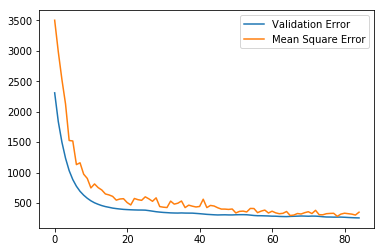

In [165]:
plt.plot(H.history['val_mean_squared_error'], label = 'Validation Error')
plt.plot(H.history['mean_squared_error'], label = 'Mean Square Error' )
plt.legend()
plt.show()

In [166]:
predictions = np.round(model_1a.predict(X_test))
np_y_test = np.array(y_test)

In [167]:
print(r2_score(predictions, np_y_test))
print(mean_absolute_error(predictions, np_y_test))

for i, j in enumerate(['HVB', 'WB ', 'BZO', 'SLIM',  'NLIM']):
    print(j, 'R2 score :', r2_score(predictions[:,i], np_y_test[:,i]), 
          'Mean Absolute Error', mean_absolute_error(predictions[:,i], np_y_test[:,i]))

-0.248804461427
9.66545454545
HVB R2 score : 0.501004457853 Mean Absolute Error 11.2363636364
WB  R2 score : -0.909661567893 Mean Absolute Error 12.8545454545
BZO R2 score : 0.177290286537 Mean Absolute Error 7.8
SLIM R2 score : -0.602865223123 Mean Absolute Error 8.12727272727
NLIM R2 score : -0.40979026051 Mean Absolute Error 8.30909090909


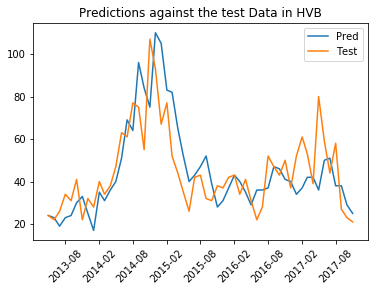

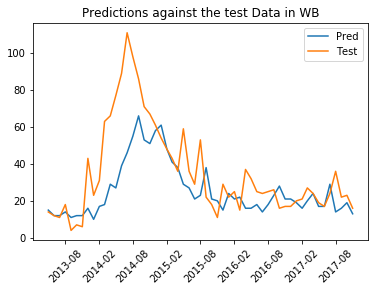

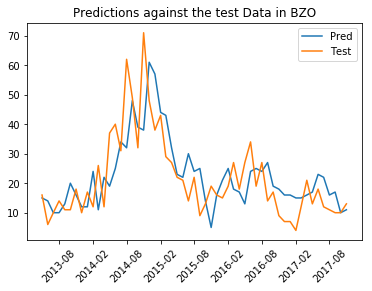

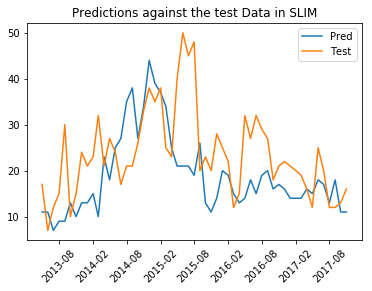

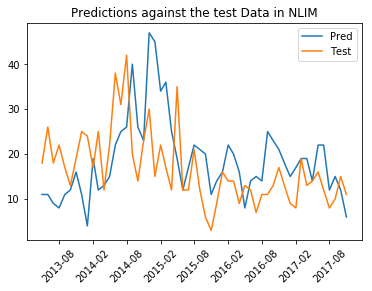

In [168]:
prediction_dataframe = pd.DataFrame({'Date' : data2['Date'][-len(y_test):], 
                         'HVB':predictions[:,0],
                       'WB': predictions[:,1],
                       'BZO': predictions[:,2],
                        'SLIM': predictions[:,3],
                        'NLIM': predictions[:,4]}).reset_index(drop = True)
prediction_dataframe['Date'] = pd.to_datetime(prediction_dataframe['Date'], format = '%Y-%m')

for i in ['HVB', 'WB', 'BZO', 'SLIM', 'NLIM']:
    plt.plot(prediction_dataframe['Date'], prediction_dataframe[i], label = 'Pred'  )
    plt.plot(prediction_dataframe['Date'], y_test[i+'+1'], label = 'Test')
    plt.legend()
    plt.title('Predictions against the test Data in '+i)
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)
    #plt.savefig('NNυ'+i, dpi = 800)
    plt.show()